In [11]:
import torch
import torch.nn as nn

import os
BASE_DIR = os.getcwd()
import pickle as pkl

import numpy as np
import pandas as pd
import random as rd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [12]:
import utils
from utils import datasets
from datasets import proper_loading, FourragesDataset
from pathlib import Path

os.chdir(BASE_DIR)

num_only_path = Path('num_only_datasets.pkl').resolve()
camemberta_path = Path('camembertav2-base_datasets.pkl').resolve()
bert_path = Path('bert-base-uncased_datasets.pkl').resolve()
ML_path = Path('models/target_normalizer_ML.pkl').resolve()

num_only_datasets = proper_loading(str(num_only_path))
camemberta_datasets = proper_loading(str(camemberta_path))
bert_datasets = proper_loading(str(bert_path))

num_only_target_normalizer = num_only_datasets["Normalizer"]["target"]
camemberta_target_normalizer = camemberta_datasets["Normalizer"]["target"]
bert_target_normalizer = bert_datasets["Normalizer"]["target"]

with open(str(ML_path), 'rb') as f:
    fichier = pkl.load(f)
    ML_target_normalizer = fichier["Normalizer"]["target"]

c:\Users\rapha\miniconda3\envs\pfr_fourrage\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

c:\Users\rapha\miniconda3\envs\pfr_fourrage\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

c:\Users\rapha\miniconda3\envs\pfr_fourrage\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.1. This 

In [28]:
def load_results(path, model):
    
    total_path = os.path.join(path+model)
    
    with open(total_path, "rb") as file:
        fichier = torch.load(file, map_location=torch.device('cpu'))
    
    if "basic" in total_path or "best" in total_path:
        predictions = np.squeeze(torch.cat(fichier["yhat"], dim=0).cpu().numpy())
        y_true = torch.cat(fichier["ytrue"], dim=0).cpu().numpy()
    elif "ML" in total_path:
        predictions = fichier["yhat"]
        y_true = fichier["ytrue"]
    else :
        raise ValueError("Mauvais chemin")
    return y_true, predictions

def normalizer_choice(model="eval_fnv_with_BERT_FT_2_epoch_5.pth", target_normalizer=True):
    
    if target_normalizer is not None:
        if "BERT" in model or "bert" in model:
            target_normalizer = bert_target_normalizer
        elif "Camembertav2" in model or "CamemBERTaV2" in model:
            target_normalizer = camemberta_target_normalizer
        elif "num_only" in model:
            target_normalizer = num_only_target_normalizer
        elif "dummy" in model or "xgb" in model:
            target_normalizer = ML_target_normalizer
        else:
            raise ValueError("Problème avec le choix du normalizer")
        
        return target_normalizer

    else:
        return None

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
target_names = ["UFL", "UFV", "BPR", "PDI", "PDIA"]

In [30]:
def plot_residuals(path="predictions/basic/", model="eval_fnv_with_BERT_FT_2_epoch_5.pth", \
    matplotlib=True, Plotly=False, target_normalizer=True):

    y_true, predictions = load_results(path, model)
    
    target_normalizer = normalizer_choice(model, target_normalizer)
    if target_normalizer is not None:
        predictions = target_normalizer.inverse_transform(predictions)
        y_true = target_normalizer.inverse_transform(y_true)

    if matplotlib:
        fig, axes = plt.subplots(len(target_names), 1, figsize=(8, 5 * len(target_names)))

        if len(target_names) == 1:  
            axes = [axes] 
        
    if matplotlib:
        for i, target in enumerate(target_names):
            
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            residuals = Y_TRUE - Y_HAT
            
            ax = axes[i]
            if matplotlib:
                plt.subplot(len(target_names), 1, i+1)
                plt.scatter(Y_TRUE, residuals, color='blue', alpha=0.7, label="Résidus")
                plt.axhline(0, color='red', linestyle='-', linewidth=1)  # Ligne y=0
                plt.xlabel("Prédictions")
                plt.ylabel("Résidus")
                plt.grid(linewidth=0.3, alpha=0.3, color='#000000')
                plt.title(f'Résidus {target} \n'
                          f'Mode : {path} \n'
                          f'Modèle : {model}' )
                plt.legend()
                plt.tight_layout()
                
                ax.grid(True)
            
    if matplotlib:    
        plt.show()

    if Plotly:
        for i, target in enumerate(target_names):
            
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            residuals = Y_TRUE - Y_HAT
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=Y_TRUE, y=residuals, mode='markers', marker=dict(color='blue'), name="Résidus"))
            fig.add_trace(go.Scatter(x=[min(Y_TRUE), max(Y_TRUE)], y=[0, 0], mode='lines', line=dict(color='red', dash='solid'), name="y=0"))
            fig.update_layout(title=f"Residuals {target}", xaxis_title="Prédictions", yaxis_title="Résidus")

            fig.update_layout(
            width=900,  # Largeur en pixels
            height=600  # Hauteur en pixels
            )
            
            fig.show()
    
plot_residuals(path="predictions/ML/", model="predictions_model_dummy.pth", matplotlib=False, Plotly=False, target_normalizer=True)


C:\Users\rapha\AppData\Local\Temp\ipykernel_31448\2879940987.py:6: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [35]:
def show_predictions(path="predictions/basic/", model="eval_fnv_with_BERT_FT_2_epoch_5.pth", \
    target_names=target_names, target_normalizer=None, matplot=True, plotly = False, save=False, save_path="./model_test.pdf"):
    
    y_true, predictions = load_results(path, model)
        
    if predictions is None or y_true is None:
        raise ValueError("Les arguments `predictions` et `true_targets` doivent être fournis.")
    
    if target_names is None:
        raise ValueError("L'argument `target_names` doit être fourni.")
    
    target_normalizer_funtion = normalizer_choice(model, target_normalizer)
    if target_normalizer_funtion is not None:
        predictions = target_normalizer_funtion.inverse_transform(predictions)
        y_true = target_normalizer_funtion.inverse_transform(y_true)

    if matplot:
        fig, axes = plt.subplots(len(target_names), 1, figsize=(6.5, 6 * len(target_names)))

        if len(target_names) == 1:  # Gestion du cas où `target_names` a un seul élément
            axes = [axes] 

        for i, target in enumerate(target_names):
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]
            
            r2 = r2_score(Y_TRUE, Y_HAT)
            rmse = root_mean_squared_error(Y_TRUE, Y_HAT)
            mae = mean_absolute_error(Y_TRUE, Y_HAT)
            mape = mean_absolute_percentage_error(Y_TRUE, Y_HAT)

            ax = axes[i] 
            sns.scatterplot(x=Y_HAT, y=Y_TRUE, palette='viridis', hue=np.abs(Y_HAT - Y_TRUE), ax=ax)
            sns.lineplot(x=Y_TRUE, y=Y_TRUE, color='red', linestyle='dashed', ax=ax)  # Ligne y = x

            ax.set_title(f'Prédictions du modèle vs vérité terrain pour {target}\n'
                         f'Modèle utilisé : {model}\n'
                         f'Mode : {path}\n'
                         f'RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')
            ax.set_xlabel(f'Predicted {target}')
            ax.set_ylabel(f'True {target}')

            ax.grid(True)
            
        plt.tight_layout()
        
        if save:
            plt.savefig(save_path, format='pdf', bbox_inches='tight')
        
        plt.show()
        
    if plotly:  
        for i, target in enumerate(target_names):
            Y_HAT = predictions[:, i]
            Y_TRUE = y_true[:, i]

            df_plot = pd.DataFrame({f'Predicted {target}': Y_HAT, f'True {target}': Y_TRUE})
            fig = px.scatter(df_plot, x=f'Predicted {target}', y=f'True {target}', 
                             color=np.abs(Y_HAT - Y_TRUE), 
                             title=f'Model Predictions vs Ground Truth for {target}',
                             color_continuous_scale='viridis', 
                             labels={'color': f'Residuals for {target}'})
            fig.add_shape(type="line", x0=min(Y_TRUE), y0=min(Y_TRUE), x1=max(Y_TRUE), y1=max(Y_TRUE),
                          line=dict(color="red", width=2, dash="dash"))
            
            fig.update_layout(
            width=800,  # Largeur en pixels
            height=600  # Hauteur en pixels
            )
            
            fig.show()


show_predictions(path="predictions/ML/", model="predictions_model_xgb.pth", matplot=False, plotly=False, target_normalizer=True)

C:\Users\rapha\AppData\Local\Temp\ipykernel_31448\2879940987.py:6: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [37]:
# import os
# import torch
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error

# def Plot_errors_models_4(mode=None, target_names=target_names, metric_fn=None, metric_name="Metric", selected_models=None, selected_mode=None, target_normalizer=True):
#     if target_names is None:
#         raise ValueError("target_names ne peut pas être None.")
#     if metric_fn is None:
#         raise ValueError("Veuillez fournir une fonction de métrique.")
#     if metric_name is None:
#         raise ValueError("Veuillez fournir un nom de métrique.")
#     if selected_models is not None and selected_mode is not None:
#         raise ValueError("Vous ne pouvez pas utiliser en même temps la séléction de modèle et la séléction de mode")
    
#     paths = {
#         "basic": os.path.join("predictions/", "basic/"),
#         "best": os.path.join("predictions/", "best/")
#     }

#     dataset = []


#     for mode_name, path in paths.items():
#         if not os.path.exists(path):
#             print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
#             continue
        
#         # print("mode :", mode)
#         # print("path :", path)
        
#         for filename in os.listdir(path):
#             if filename.endswith(".pth"):
#                 file_path = os.path.join(path, filename)
#                 with open(file_path, "rb") as file:
#                     data = torch.load(file, map_location=torch.device('cpu'))

#                 # Y_HAT = data["yhat"]
#                 # Y_TRUE = data["ytrue"]
                
#                 Y_HAT = torch.cat(data["yhat"], dim=0).cpu().numpy()
#                 Y_TRUE = torch.cat(data["ytrue"], dim=0).cpu().numpy()
                
#                 # print("Y_HAT",  Y_HAT.shape, "\n", "Y_TRUE", Y_TRUE.shape)

#                 print(filename)
#                 # if 'dummy' in filename or 'xgb' in 
#                 target_normalizer_funtion = normalizer_choice(model=filename, target_normalizer=target_normalizer)
#                 # print(target_normalizer_funtion)
#                 if target_normalizer_funtion is not None:
#                     # print(Y_HAT, Y_TRUE)
#                     Y_HAT = target_normalizer_funtion.inverse_transform(Y_HAT)
#                     Y_TRUE = target_normalizer_funtion.inverse_transform(Y_TRUE)
                
#                 for i in range(len(target_names)):
#                     predictions = Y_HAT[:, i]
#                     y_true = Y_TRUE[:, i]
                    
#                     # print("predictions :", y_true.shape)

#                     metric_value = metric_fn(y_true, predictions)
#                     dataset.append([filename, target_names[i], metric_value, mode_name])

#     df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
    
#     # print(df)

#     if selected_models is not None:
#         df = df[df["Modèle"].isin(selected_models)]
#     if selected_mode is not None:
#         df = df[df["Mode"] == selected_mode]
        
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(12, 6))

#     sns.barplot(
#         data=df,
#         x="Modèle",
#         y=metric_name,
#         hue="Cible",
#         palette="viridis",
#         dodge=True
#     )

#     plt.title(f"Comparaison des modèles ({'basic & best' if selected_mode is None else selected_mode}) \n métrique : {metric_name}")
#     plt.xlabel("Modèle")
#     plt.ylabel(metric_name)
#     plt.xticks(rotation=90)
#     plt.legend(title="Cible")
#     plt.show()

# Plot_errors_models_4(metric_fn=mean_absolute_error, metric_name="MAE", selected_models=None, selected_mode=None, target_normalizer=True)

C:\Users\rapha\AppData\Local\Temp\ipykernel_31448\3572552938.py:35: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\rapha\AppData\Local\Temp\ipykernel_31448\357255293

                                           Modèle Cible        R2   Mode
0          eval_fnv_with_bert-base-uncased_10.pth   UFL  0.752673  basic
1          eval_fnv_with_bert-base-uncased_10.pth   UFV  0.758514  basic
2          eval_fnv_with_bert-base-uncased_10.pth   BPR  0.956536  basic
3          eval_fnv_with_bert-base-uncased_10.pth   PDI  0.855110  basic
4          eval_fnv_with_bert-base-uncased_10.pth  PDIA  0.860373  basic
5             eval_fnv_with_BERT_FT_2_epoch_5.pth   UFL  0.823976  basic
6             eval_fnv_with_BERT_FT_2_epoch_5.pth   UFV  0.779990  basic
7             eval_fnv_with_BERT_FT_2_epoch_5.pth   BPR  0.978472  basic
8             eval_fnv_with_BERT_FT_2_epoch_5.pth   PDI  0.872172  basic
9             eval_fnv_with_BERT_FT_2_epoch_5.pth  PDIA  0.879820  basic
10         eval_fnv_with_camembertav2-base_10.pth   UFL  0.743047  basic
11         eval_fnv_with_camembertav2-base_10.pth   UFV  0.767045  basic
12         eval_fnv_with_camembertav2-base_10.pth  

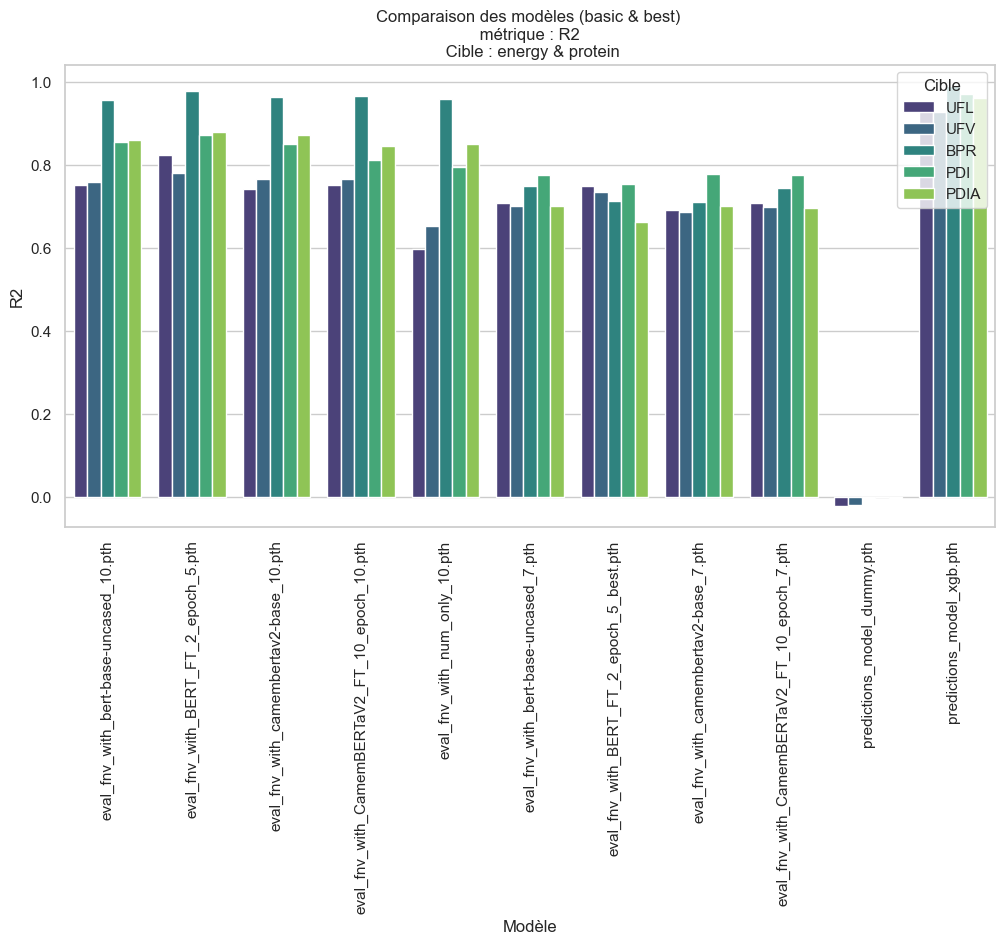

In [52]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def Plot_errors_models_5(target_names=target_names, metric_fn=None, metric_name="Metric", selected_models=None, selected_mode=None, selected_target='energy', target_normalizer=True):
    if target_names is None:
        raise ValueError("target_names ne peut pas être None.")
    if metric_fn is None:
        raise ValueError("Veuillez fournir une fonction de métrique.")
    if metric_name is None:
        raise ValueError("Veuillez fournir un nom de métrique.")
    if selected_models is not None and selected_mode is not None:
        raise ValueError("Vous ne pouvez pas utiliser en même temps la séléction de modèle et la séléction de mode")
    
    paths = {
        "basic": os.path.join("predictions/", "basic/"),
        "best": os.path.join("predictions/", "best/"),
        "ML": os.path.join("predictions/", "ML/")
    }

    dataset = []

    for mode_name, path in paths.items():
        if not os.path.exists(path):
            print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
            continue
        
        for filename in os.listdir(path):
            if filename.endswith(".pth"):
                file_path = os.path.join(path, filename)
                with open(file_path, "rb") as file:
                    data = torch.load(file, map_location=torch.device('cpu'))
                
                if "basic" in file_path or "best" in file_path:
                    Y_HAT = torch.cat(data["yhat"], dim=0).cpu().numpy()
                    Y_TRUE = torch.cat(data["ytrue"], dim=0).cpu().numpy()
                elif "ML" in file_path:
                    Y_HAT = data["yhat"]
                    Y_TRUE = data["ytrue"]

                target_normalizer_funtion = normalizer_choice(model=filename, target_normalizer=target_normalizer)
                if target_normalizer_funtion is not None:
                    Y_HAT = target_normalizer_funtion.inverse_transform(Y_HAT)
                    Y_TRUE = target_normalizer_funtion.inverse_transform(Y_TRUE)
                
                for i in range(len(target_names)):
                    predictions = Y_HAT[:, i]
                    y_true = Y_TRUE[:, i]
                    
                    metric_value = metric_fn(y_true, predictions)
                    dataset.append([filename, target_names[i], metric_value, mode_name])
                    
                    # if "ML" in file_path:
                    #     print("Y_HAT :", predictions.shape, "Y_TRUE :", y_true.shape)

    df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
    
    print(df)

    if selected_models is not None:
        df = df[df["Modèle"].isin(selected_models)]
    if selected_mode is not None:
        df = df[df["Mode"] == selected_mode]
    if selected_target is not None:
        if selected_target == 'energy':
            df = df[df["Cible"].isin(["UFL", "UFV"])]
        elif selected_target == 'protein':
            df = df[df["Cible"].isin(["BPR", "PDI", "PDIA"])]
        else:
            raise ValueError("selected_target must be either 'energy' or 'protein'")
                
    # print(df)
        
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=df,
        x="Modèle",
        y=metric_name,
        hue="Cible",
        palette="viridis",
        dodge=True
    )

    plt.title(f"Comparaison des modèles ({'basic & best' if selected_mode is None else selected_mode}) \n métrique : {metric_name} \n Cible : {selected_target if selected_target is not None else 'energy & protein'}")
    plt.xlabel("Modèle")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.legend(title="Cible")
    plt.show()

Plot_errors_models_5(metric_fn=r2_score, metric_name="R2", selected_models=None, selected_mode=None, selected_target=None, target_normalizer=False)

# autre

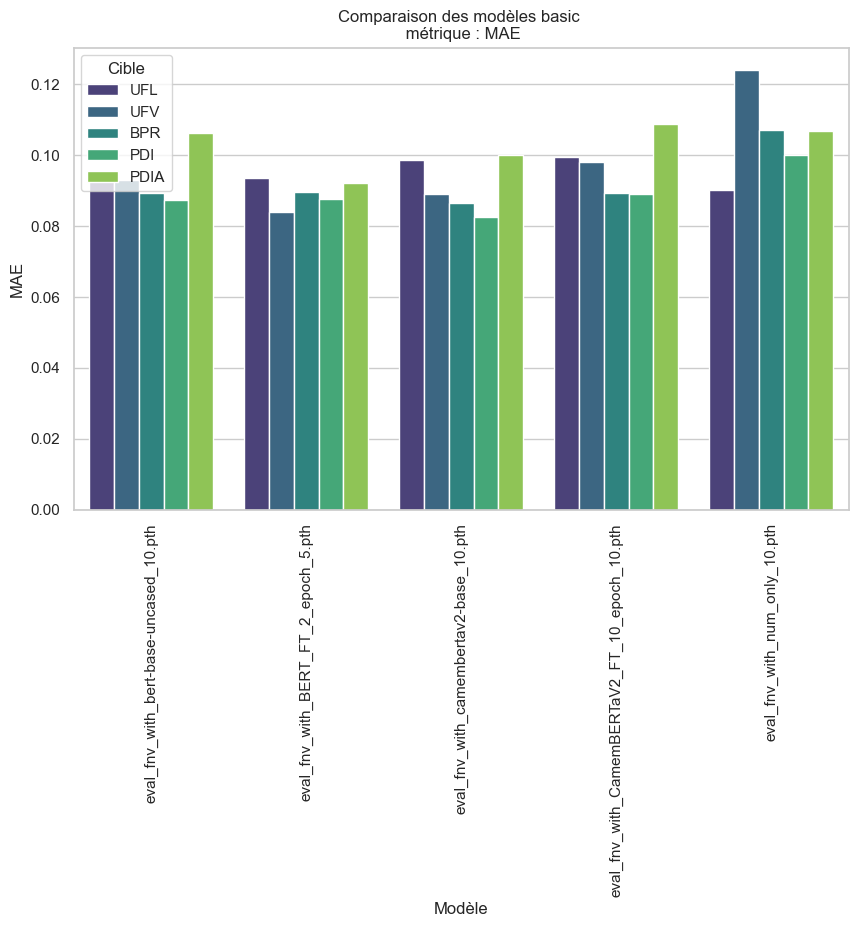

In [164]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def Plot_errors_models_2(mode="basic", target_names=None, metric_fn=None, metric_name="Metric"):
    if target_names is None:
        raise ValueError("target_names ne peut pas être None.")

    if metric_fn is None:
        raise ValueError("Veuillez fournir une fonction de métrique.")

    if mode == "basic":
        total_path = os.path.join("predictions/", "basic/")
    elif mode == "best":
        total_path = os.path.join("predictions/", "best/")
    else:
        raise ValueError("Mode non valide. Choisissez 'basic' ou 'best'.")

    if not os.path.exists(total_path):
        raise FileNotFoundError(f"Le répertoire {total_path} n'existe pas.")

    dataset = []

    for filename in os.listdir(total_path):
        if filename.endswith(".pth"):
            file_path = os.path.join(total_path, filename)
            with open(file_path, "rb") as file:
                data = torch.load(file, map_location=torch.device('cpu'))

            Y_HAT = data["yhat"]
            Y_TRUE = data["ytrue"]

            for i in range(len(target_names)):
                predictions = Y_HAT[i].tolist()
                y_true = Y_TRUE[i].tolist()

                metric_value = metric_fn(y_true, predictions)
                dataset.append([filename, target_names[i], metric_value])

    df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name])
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    g = sns.barplot(
        data=df,
        x="Modèle",
        y=metric_name,
        hue="Cible",
        palette="viridis",
        dodge=True
    )

    plt.title(f"Comparaison des modèles {mode} \n métrique : {metric_name}")
    plt.xlabel("Modèle")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)
    plt.legend(title="Cible")
    plt.show()


Plot_errors_models_2(mode="basic", target_names=target_names, metric_fn=mean_absolute_error, metric_name="MAE")




In [ ]:
# import os
# import torch
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def plot_errors_models_3(target_names=target_names, metric_fn=None, metric_name="Metric"):
#     """
#     Charge les prédictions des modèles de "basic" et "best", calcule une métrique et affiche un histogramme.

#     Arguments :
#     - target_names : list, noms des cibles utilisées pour la prédiction.
#     - metric_fn : fonction, métrique à utiliser (ex: mean_absolute_error, mean_squared_error).
#     - metric_name : str, nom de la métrique affichée dans le graphe.

#     Retourne :
#     - None (affiche directement un histogramme avec Seaborn)
#     """
#     if target_names is None:
#         raise ValueError("target_names ne peut pas être None.")
#     if metric_fn is None:
#         raise ValueError("Veuillez fournir une fonction de métrique.")

#     paths = {
#         "basic": os.path.join("predictions/", "basic/"),
#         "best": os.path.join("predictions/", "best/")
#     }
# #
#     dataset = []

#     for mode, path in paths.items():
#         if not os.path.exists(path):
#             print(f"Avertissement : Le répertoire {path} n'existe pas. Il sera ignoré.")
#             continue  

#         for filename in os.listdir(path):
#             if filename.endswith(".pth"):
#                 file_path = os.path.join(path, filename)
#                 with open(file_path, "rb") as file:
#                     data = torch.load(file, map_location=torch.device('cpu'))

#                 Y_HAT = data["yhat"]
#                 Y_TRUE = data["ytrue"]

#                 for i in range(len(target_names)):
#                     predictions = Y_HAT[i].tolist()
#                     y_true = Y_TRUE[i].tolist()

#                     metric_value = metric_fn(y_true, predictions)
#                     dataset.append([filename, target_names[i], metric_value, mode])

#     df = pd.DataFrame(dataset, columns=["Modèle", "Cible", metric_name, "Mode"])
#     print(df)

#     # Affichage du graphique Seaborn
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(12, 6))

#     g = sns.barplot(
#         data=df,
#         x="Modèle",
#         y=metric_name,
#         hue="Cible",
#         palette="viridis",
#         dodge=True
#     )

#     plt.title(f"Comparaison des modèles ('basic' vs 'best') \n Métrique : {metric_name}")
#     plt.xlabel("Modèle")
#     plt.ylabel(metric_name)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title="Cible")
#     plt.show()


# plot_errors_models_3(target_names, metric_fn=mean_absolute_error, metric_name="MAE")
